# Задание

На нашем сайте есть открытая информация, касающаяся машин на линии, зон работы сервиса итд
Она лежит тут: http://youdrive.today/info

1. Что можно сказать про наш автопарк? Какие самые частые машины в разных городах/зонах? 

2. Какое распределение имеют машины по уровню топлива?

3. Насколько часто используется режим "Передача" (это специальный режим, когда пользователь может оставить машину вне зоны завершения аренды и платить небольшую стоимость за то время, пока машину не заберет кто-то другой: https://youdrive.today/rates)? Может имеет смысл расширять нашу зону в места, где часто оставляют машины с помощью этой функции? Как вообще можно принимать решение о том, как менять наши зоны работы?

4. Представьте, что вы работаете в конкурирующей компании. Какие наши операционные данные можно оценить по этим данным? Как это сделать? 

# Загрузка данных разведовательный анализ и предобработка датасета

Подгружаем библиотеки, которые будем использовать в анализе.

In [1]:
import pandas as pd
import requests 
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")

Загрузим данные с сайта, преобразуем их в словарь, посмотрим, какие данные опубликованы на сайте.

In [2]:
raw_data = requests.get('http://youdrive.today/info').json()
print(raw_data.keys())

dict_keys(['cars', 'area', 'areas', 'area_groups', 'layers', 'success'])


Полученные данные содержат сведения о шести объектах. Проведём разведовательный анализ данных для каждого объекта.

### Cars

In [3]:
cars = pd.DataFrame(raw_data['cars'])
display(cars.info())
display(cars.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2808 entries, 0 to 2807
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   latitude      2808 non-null   float64
 1   longitude     2808 non-null   float64
 2   pin_img       2808 non-null   object 
 3   color         2808 non-null   object 
 4   model         2808 non-null   object 
 5   img           2808 non-null   object 
 6   transmission  2808 non-null   object 
 7   fuel          2808 non-null   int64  
 8   discount      2808 non-null   int64  
 9   is_parther    2808 non-null   bool   
dtypes: bool(1), float64(2), int64(2), object(5)
memory usage: 200.3+ KB


None

,latitude,longitude,pin_img,color,model,img,transmission,fuel,discount,is_parther
0,59.994936,30.233486,https://youdrive.today/static/resources/car_po...,black,Nissan Qashqai,https://youdrive.today/static/cars/v3/poolstar...,automatic,100,0,False
1,55.805028,37.818712,https://youdrive.today/static/resources/car_po...,white,Nissan Qashqai,https://youdrive.today/static/cars/v3/poolstar...,automatic,68,0,False
2,55.738604,37.691464,https://youdrive.today/static/resources/car_po...,black,Nissan Qashqai,https://youdrive.today/static/cars/v3/poolstar...,automatic,73,0,False
3,59.853280,30.146634,https://youdrive.today/static/resources/car_po...,white,Nissan Qashqai,https://youdrive.today/static/cars/v3/poolstar...,automatic,70,0,False
4,55.761244,37.723276,https://youdrive.today/static/resources/car_po...,white,Nissan Qashqai,https://youdrive.today/static/cars/v3/poolstar...,automatic,90,0,False


Датасет cars содержит сведения об автомобилях: координаты местоположения, изображения автомобиля, цвет, модель, сведения о запасе топлива, какой-то дисконт, и признак is_partner. 

Проанализируем эти признаки, написав для этого функцию.

In [4]:
for item in cars.columns:
    print(cars[item].dtype == 'object')

False
False
True
True
True
True
True
False
False
False


In [5]:
def eda(dataset, column, bins=10):

    column = dataset[column]

    display(column.describe())
    display(round(column.value_counts(dropna=False, normalize=True)*100, 2))

    if column.dtype == 'object' or column.dtype == 'bool':
        sns.countplot(x=column.name, data=dataset, color='b').set_title(
            column.name.upper(), fontdict={'fontsize': 16})
    else:
        sns.histplot(data=dataset, x=column.name, bins=bins, color='b').set_title(
            column.name.upper(), fontdict={'fontsize': 16})

count      2808
unique       10
top       white
freq       1451
Name: color, dtype: object

white        51.67
black        18.98
gray         12.54
silver        8.69
blue          3.81
dark gray     3.53
brown         0.43
orange        0.18
red           0.11
yellow        0.07
Name: color, dtype: float64

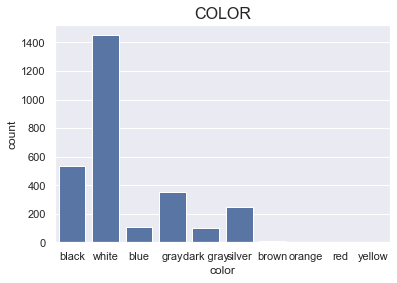

In [6]:
eda(cars, 'color')

Видим, что в датасете 2758 автомобилей. Более половины автомобилей имеют белый цвет. Также видим одну аномалию: в датасете присутствует описание цвета на русском языке, тогда как большинство признаков указано на английском. Исправим это, и проанализируем признак transmission.

In [7]:
cars.color = cars.color.replace('Белый','white')

count          2808
unique            2
top       automatic
freq           2807
Name: transmission, dtype: object

automatic    99.96
robot         0.04
Name: transmission, dtype: float64

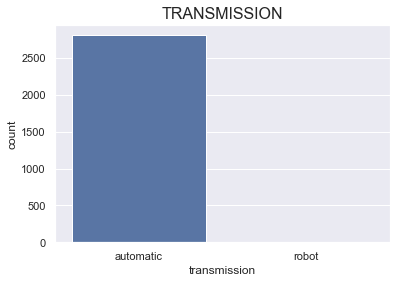

In [8]:
eda(cars, 'transmission')

Видим, что все автомобили за исключением одного имеют автоматическую трансмиссию. По видимому, данный признак нам не понадобится для дальнейшего анализа.

Проанализируем признак discount.

count    2808.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: discount, dtype: float64

0    100.0
Name: discount, dtype: float64

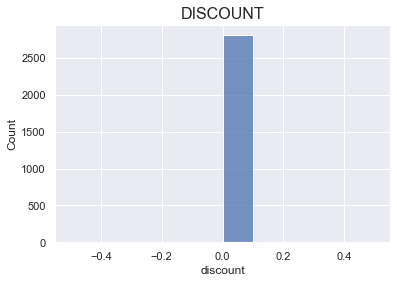

In [9]:
eda(cars, 'discount')

Непонятно, что это означает, но он у всех автомобилей равен нулю. Возможно, это скидки к действующим тарифам, которые могут быть применены для некоторых автомобилей.

Проанализируем признак is_parther.

count      2808
unique        1
top       False
freq       2808
Name: is_parther, dtype: object

False    100.0
Name: is_parther, dtype: float64

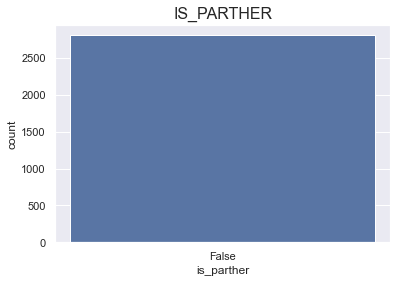

In [10]:
eda(cars, 'is_parther')

Везде значение 'ложь'. Предположительно, этот признак означает, что автомобиль принадлежит третьему лицу и находится в доверительном управлении у YouDrive. Вероятно, таких автомобилей сейчас нет.

Проанализируем признак fuel.

count    2808.000000
mean       67.174145
std        21.751076
min         3.000000
25%        52.000000
50%        69.000000
75%        85.000000
max       100.000000
Name: fuel, dtype: float64

100    7.19
90     4.38
57     3.31
83     2.92
77     2.85
       ... 
3      0.07
10     0.04
99     0.04
7      0.04
8      0.04
Name: fuel, Length: 92, dtype: float64

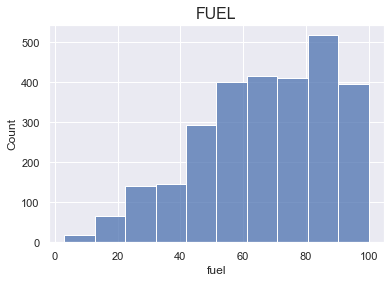

In [11]:
eda(cars, 'fuel')

Видно, что все значения признака fuel находятся в интервале от 0 до 100. Вероятно, этот признак обозначает запасы топлива в процентах.

Добавим в датасет ещё один признак: топливо, потреблённое после заправки.

count    2808.000000
mean       32.825855
std        21.751076
min         0.000000
25%        15.000000
50%        31.000000
75%        48.000000
max        97.000000
Name: fuel_cons, dtype: float64

0     7.19
10    4.38
43    3.31
17    2.92
23    2.85
      ... 
81    0.07
93    0.04
92    0.04
1     0.04
90    0.04
Name: fuel_cons, Length: 92, dtype: float64

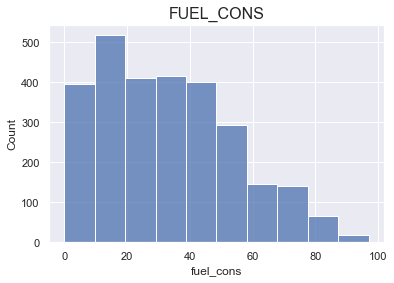

In [12]:
cars['fuel_cons'] = cars.fuel.apply(lambda x: 100-x)
eda(cars, 'fuel_cons')

Попытаемся выдвинуть гипотезу, какое распределение имеют машины по уровню топлива.

Предположим, что потребление топлива происходит с некоторой средней скоростью. В таком случае с некоторой средней частотой будут происходить события по заправке автомобилей топливом. В случае наступления указанного события уровень топлива повышается до 100%.

Нам не известно, с какой средней интенсивностью потребляется топливо, с какой частотой происходит заправка, и какое распределение имеют эти параметры.

Предположим, что уровень топлива оперделяется функцией: $$P = 100 - V \times T,$$

где $P$ - уровень топлива;
$V$ - скорость потребления топлива;
$T$ - время прошедшее с момента последней заправки. 

Предположим, что заправка происходит через интервалы времени $X$, после которой уровень топлива становится равным 100. В таком случае имеем уравнение: $$(100-P_п)= V\times X,$$

где $P_п$ - уровень при котором происходит заправка автомобиля.

Далее получим, что :$$P = 100 - (100-P_п) \frac {T}{X} $$.

Таким образом, получаем, что случайная величина Р - это функция трёх случайных величин.

Из статистики известно, что интервалы времени между независимыми событиями, происходящими со средней интенсивностью  $λ$ описываются экспоненциальным распределением. Таким образом, предположим, что $X$ имеет экспоненциальное распределение.

Нам не известны условия, при которых производится заправка автомобиля. Это может быть уровень топлива, например, менее 20%. Таким образом, $Р_п$ - это случайная величина, имеющая закон распределения, который нам не известен. Предположительно, она не зависит от других случайных величин, представленных в формуле.

Время $T$, прошедшее с момента предыдущей заправки. Очевидно, что распределение этой случайной величины зависит от  $X$.

Попробуем найти матожидание $P$: $$M[P] = 100 - M[100-P_п] \times M[\frac {T}{X}]=$$

$$ = 100 - (100 - М[P_п]) \times (M[T] \times M[\frac{1}{T}] + K_{\frac{1}{X} T}))$$

Аналогичным образом можно вывести формулу для дисперсии.

Выдвенем нулевую гипотезу, что распределение потреблённого топлива fuel_cons подчиняется экспоненциальному распределению при уровне значимости 10%.

In [13]:
from scipy.stats import expon

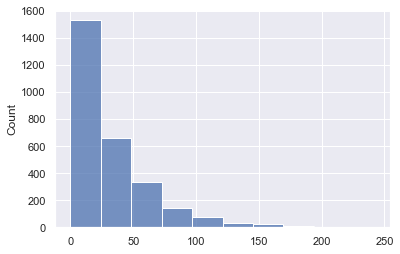

In [14]:
sns.histplot(data=expon.rvs(loc=0, scale=cars.fuel_cons.
                            describe()['mean'],
                            size=int(cars.fuel_cons.describe()['count'])), bins=10, color='b');

По гистограмме видно, что теоретическое распределение сильно отличается от фактического, поэтому нулевую гипотезу отвергаем без статистической проверки.

Проверим, какие модели имеются в наличии.

count               2871
unique                21
top       Nissan Qashqai
freq                1698
Name: model, dtype: object

Nissan Qashqai           59.14
VW Polo                   9.44
smart fortwo              6.55
Kia Rio                   5.22
Hyundai Creta             3.07
Kia Rio X-line            2.40
Hyundai Solaris           1.78
smart forfour             1.74
Kia Soul                  1.53
MINI Cooper               1.46
Electric scooter lite     1.39
forfour turbo             1.22
BMW Active Tourer         1.08
fortwo turbo              1.04
Mercedes A-class          0.91
Kia Picanto               0.84
Nissan X-Trail            0.77
Renault Kaptur            0.24
forfour soft-top          0.10
Renault Arkana            0.03
Mercedes A200             0.03
Name: model, dtype: float64

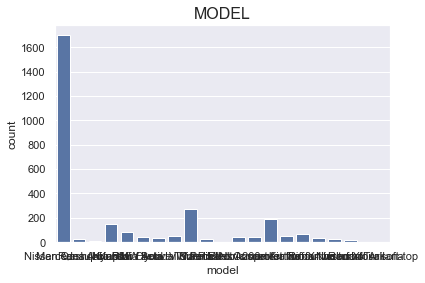

In [43]:
eda(cars, 'model')

Визуализируем автомобили на карте

In [18]:
import folium

In [29]:
m = folium.Map(location=[55.75, 37.616667], zoom_start=4)
for i in range(0, len(cars)):
    color='green'
    folium.Marker(location=[cars.iloc[i, 0], cars.iloc[i, 1]]).add_to(m)
display(m)

Выгрузим данные с сайта с определённым интервалом, чтобы посмотреть, как меняется количество машин с течением времени. Создадим базу данных для сохранения результатов. Будем выгружать данные каждые пять минут в течение 10 часов.

In [44]:
import sqlite3
import time
import datetime

In [39]:
conn = sqlite3.connect('YouDrive.db')
c = conn.cursor()
c.executescript(
    
"""
CREATE TABLE IF NOT EXISTS cars (
    latitude REAL,
    longitude REAL,
    color TEXT,
    model TEXT,
    fuel REAL,
    time TEXT DEFAULT CURRENT_TIMESTAMP
    )
"""
                )

conn.commit()
conn.close()

In [ ]:
for i in range(0,120):
    cars = pd.DataFrame(requests.get('http://youdrive.today/info').json()['cars'])
    cars = cars[['latitude', 'longitude', 'color', 'model', 'fuel']]
    conn = sqlite3.connect('YouDrive.db')
    cars.to_sql('cars', conn, if_exists='append', index=False)
    conn.close()
    print('Данные выгружены в {}'.format(datetime.datetime.now()))
    time.sleep(300)

Данные выгружены в 2020-10-17 21:01:21.843692
Данные выгружены в 2020-10-17 21:06:22.686231
Данные выгружены в 2020-10-17 21:11:23.559521
Данные выгружены в 2020-10-17 21:16:24.542921
Данные выгружены в 2020-10-17 21:21:25.363575
Данные выгружены в 2020-10-17 21:26:25.938692
Данные выгружены в 2020-10-17 21:31:26.837889
Данные выгружены в 2020-10-17 21:36:27.687352
Данные выгружены в 2020-10-17 21:41:28.589842
Данные выгружены в 2020-10-17 21:46:29.009511
Данные выгружены в 2020-10-17 21:51:29.189709
Данные выгружены в 2020-10-17 21:56:30.113233
Данные выгружены в 2020-10-17 22:01:31.025306
Данные выгружены в 2020-10-17 22:06:31.941436
Данные выгружены в 2020-10-17 22:11:32.743879
Данные выгружены в 2020-10-17 22:16:33.585805
Данные выгружены в 2020-10-17 22:21:34.597961
Данные выгружены в 2020-10-17 22:26:35.517567
Данные выгружены в 2020-10-17 22:31:35.959948
